<font color='darkred'>**Nota: la siguiente celda sirve para poder ocultar/mostrar las cajas del resto de código según convenga seleccionando el botón. Es necesario correrla en el caso de querer hacer uso de su funcionalidad (en el archivo .ipynb).**</font>

In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings("ignore")

# Contenido

1. [Introducción.](#1.-Introducción) Breve explicación del método de transformación de los datos y exploración de la tabla inicial.
2. [Evaluación de modelos.](#2.-Evaluación-de-modelos) Comparación de varios modelos para la clasificación de los datos en parentales y resistentes.  
2.1. [Primera aproximación.](#2.1.-Primera-aproximación:-Árbol-de-Decisión,-Random-Forest,-Gradient-Boosting,-y-Regresión-Logística-con-regularización-L1) Evaluación de Árbol de Decisión, *Random Forest*, *Gradient Boosting*, y Regresión Logística con regularización L1.  
<font color='white'>tab </font>2.1.1. [Construcción de un clasificador *Random Forest*.](#2.1.1-Construcción-de-un-clasificador-Random-Forest)  
<font color='white'>tab </font>2.1.2. [Validación del modelo de *Random Forest*.](#2.1.2.-Validación)  
2.2. [Segunda aproximación.](#2.2.-Segunda-aproximación:-selección-de-genes-de-manera-previa-a-la-construcción-del-modelo) Selección de genes de manera previa a la construcción de SVM, Árbol de Decisión, *Gradient Boosting*, Regresión Logística sin y con regularización L2.  
<font color='white'>tab </font>2.2.1. [Selección de genes.](#2.2.1.-Selección-de-genes) Selección del número más adecuado para la construcción del modelo elegido (SVM) según *Random Forest*.  
<font color='white'>tab </font>2.2.2. [Construcción de SVM con 8 genes.](#2.2.2.-Construcción-de-un-clasificador-SVM-(con-8-genes)) Selección del número más adecuado para la construcción del modelo elegido (SVM) según *Random Forest*.  
<font color='white'>tab </font>2.2.3. [Validación del modelo de SVM.](#2.2.3.-Validación) Selección del número más adecuado para la construcción del modelo elegido (SVM) según *Random Forest*.  
3. [Resultados y conclusiones.](#3.-Resultados-y-conclusiones)

# 1. Introducción

Para la construcción de un clasificador capaz de distinguir las células resistentes y parentales, se partió de una tabla de datos de 52 muestras de las dos categorías que mostraba una medida de expresión relativa de los 259 genes diferencialmente expresados según los metaanálisis realizados. En concreto, estas medidas relativas se obtuvieron en R ordenando primero todos los genes que devuelve [tximeta](https://bioconductor.org/packages/release/bioc/html/tximeta.html), dando la misma posición a los valores iguales. Después, se dividió cada posición entre la máxima del ránking y se multiplicó por 100, de manera que qudaron valores del rango $(0, 100]$ asociados a cada uno de los genes en cada muestra. Como ejemplo ilustrativo, se puede partir de la siguiente tabla de expresión en una muestra:

|  | TPM |
| --- | --- |
| Gen A | 0 |
| Gen B | 7 | 
| Gen C | 3 |
| Gen D | 0 |
| Gen E | 5 |

Los valores relativos se obtendrían ordenando en un ránking los valores de TPM, dividiendo entre 4 y multiplicando por 100:

|  | TPM | Ránking | Expresión relativa |
| --- | --- | --- | --- |
| Gen A | 0 | 1 | 25 | 
| Gen B | 7 | 4 | 100 |
| Gen C | 3 | 2 | 50 |
| Gen D | 0 | 1 | 25 |
| Gen E | 5 | 3 | 75 |

De esta manera, la expresión de un gen queda definida de manera relativa al resto, y el modelo construido a partir de estos valores puede ser utilizado con otros conjuntos de datos que usen métodos de normalización distintos de los TPM. Como ya se ha mencionado antes, para la generación del modelo se seleccionaron únicamente los 259 genes que mostraron estar diferencialmente expresados según los metaanálisis de resistencia. La tabla de datos de la que se parte tiene el siguiente aspecto:

In [2]:
data = pd.read_table("data/norm-data-tpms.txt")

In [3]:
data.head()

,ENSG00000149596,ENSG00000183671,ENSG00000231290,ENSG00000125398,ENSG00000147100,ENSG00000047936,ENSG00000184545,ENSG00000182326,ENSG00000000971,ENSG00000055813,...,ENSG00000176438,ENSG00000285816,ENSG00000021762,ENSG00000131697,ENSG00000165233,ENSG00000012061,ENSG00000166886,ENSG00000137700,ENSG00000228397,phenotype
singleton.Sample1.A375.P,15.572589,11.914700,2.735828,72.152235,13.098581,33.421871,4.242240,46.930257,52.993853,4.819003,...,51.734082,67.492601,55.008727,58.006375,78.872277,94.376565,84.977613,78.572513,31.551188,P
singleton.Sample2.A375.P,17.998626,14.735516,6.201817,71.334249,19.613007,32.909702,5.698038,49.465690,52.583772,2.041829,...,50.725135,69.620640,56.110221,53.369972,77.009389,94.141669,83.394397,80.146554,34.650027,P
singleton.Sample3.A375.P,19.762952,18.921812,21.812273,70.992162,13.202065,35.809597,4.438922,42.137259,54.582298,15.725483,...,51.198624,67.830243,57.350411,56.784554,78.550946,93.664691,83.333971,79.434143,35.916651,P
singleton.Sample4.A375.R,45.968364,47.229938,54.598765,79.837963,47.083333,75.142747,43.672840,66.782407,71.589506,10.455247,...,44.614198,64.101080,47.322531,53.167438,67.044753,92.403549,79.243827,74.618056,32.854938,R
singleton.Sample5.A375.R,47.413566,42.673338,53.414093,80.591400,48.444378,76.818028,46.078026,69.756593,70.520296,17.429743,...,44.836537,63.804973,49.501524,54.106317,69.365336,90.384109,79.583161,77.062563,24.193973,R


Y las siguientes dimensiones:

In [4]:
print('Rows: %d\nColumns: %d' % data.shape)

Rows: 52
Columns: 260


Los datos están balanceados porque hay un proporción parecida de las dos categorías:

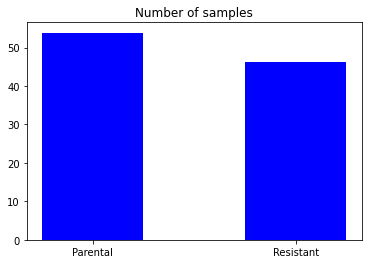

In [5]:
ab = sum(data['phenotype'] == 'P')/len(data['phenotype'])*100, sum(data['phenotype']=='R')/len(data['phenotype'])*100
plt.bar((1, 2), ab, width = 0.5, color='blue')
plt.title('Number of samples')
plt.xticks((1, 2), ('Parental', 'Resistant'));

Un resumen de los 259 genes seleccionados y sus valores relativos:

In [6]:
data.describe()

,ENSG00000149596,ENSG00000183671,ENSG00000231290,ENSG00000125398,ENSG00000147100,ENSG00000047936,ENSG00000184545,ENSG00000182326,ENSG00000000971,ENSG00000055813,...,ENSG00000184640,ENSG00000176438,ENSG00000285816,ENSG00000021762,ENSG00000131697,ENSG00000165233,ENSG00000012061,ENSG00000166886,ENSG00000137700,ENSG00000228397
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,23.533002,25.845995,33.160896,38.945845,33.773518,22.272838,32.684519,57.742887,35.272792,9.989135,...,97.482293,55.402763,52.617262,65.821097,62.568709,83.882161,94.229063,80.229290,71.805431,25.740622
std,27.328325,26.025269,28.593092,31.820862,18.865808,24.813433,20.497122,19.100354,27.137994,16.464861,...,1.368293,10.724231,14.565553,8.473163,7.089185,7.096954,3.068996,5.353870,6.420738,8.805277
min,0.004084,0.003635,0.003674,0.003674,2.395144,0.004015,0.004084,17.159203,0.003674,0.002909,...,94.148006,30.727219,0.003931,47.322531,49.067749,67.044753,83.756301,69.686440,51.503565,6.792274
25%,3.594211,3.715832,8.950721,7.452975,18.911372,3.513017,15.536091,41.437664,5.971093,0.003878,...,96.275166,49.125898,42.891866,60.164768,57.478899,78.818320,92.373650,76.375648,67.979949,20.018168
50%,9.522993,17.612983,25.495940,33.825993,30.479157,11.783298,35.873370,61.361378,32.249588,0.859162,...,97.927579,54.124476,55.776124,66.122108,60.879474,85.241137,94.421747,79.671130,72.055163,24.849509
75%,34.009769,41.259480,51.268891,71.077684,47.809294,34.018803,49.952008,73.014362,60.009483,11.998280,...,98.455379,63.745837,63.879000,72.430420,67.716547,89.251146,96.317300,84.930040,76.720495,31.640084
max,80.874137,88.934018,89.355964,94.415457,74.669136,76.818028,67.546056,93.853731,82.561605,58.997332,...,99.180229,74.604300,74.857329,81.739579,76.687141,93.452063,98.507463,90.830871,82.321556,45.528366


La siguiente matriz muestra la correlación entre los 259 genes:

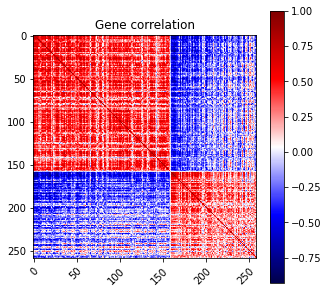

In [7]:
# Generates correlation matrix
corr_mx = data.corr()
features = data.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (5,5))
plt.imshow(corr_mx, cmap = 'seismic')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()


Se observan dos grupos de genes que corresponden con los genes inducidos y reprimidos en resistencia. La correlación entre los genes puede influir en la actuación de los modelos por multicolinearirdad, haciendo que obtengan resultados erróneos. Por este motivo, se entrenarán árboles de decisión y otros métodos "ensemble" basados en ellos cuya actuación no se ve afectada por este tipo de dificultades. Además, para probar otros modelos, se realizará una selección de genes que, además de controlar la multicolinearidad, también ayudará a reducir la dimensionalidad de los datos para evitar el riesgo de sobreajuste.

# 2. Evaluación de modelos

## 2.1. Primera aproximación: Árbol de Decisión, *Random Forest*, *Gradient Boosting*, y Regresión Logística con regularización L1

Como primera aproximación, se entrenarán clasificadores que utilizan los genes más útiles para la separación de las categorías, haciendo así una selección de ellos. En concreto, se utilizarán árboles de decisión, *Random Forest* y *Gradient Boostig* (métodos "ensemble" basados en árboles de decisión) y regresión logística con regularización L1. Su evaluación se hará mediante validación cruzada con una división aleatoria de los datos en 10 subgrupos que se repetirá 10 veces, construyendo así 100 modelos de cada tipo.

Los errores en cada una de las iteraciones se calculará con la siguiente expresión:

$$error = 1-\frac{TP + TR}{TP + TR + FP + FR},$$

donde FP hace referencia a las resistentes clasificadas como parentales, FR a las parentales clasificadas como resistentes, y TP y TR a las clasificaciones correctas.

Los errores de cada modelo obtenido tras la validación cruzada fueron:

In [3]:
X = data.values[ :, :-1].astype(np.float)
y = (data.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [35]:
split = 0

# random forest
rf = RandomForestClassifier(n_jobs = -1, random_state = split)
# gradient boosting
gb = GradientBoostingClassifier()
# decision tree
dt = DecisionTreeClassifier(random_state = split)
# logreg + l1 penalty to train the model
logregl1 = LogisticRegression(penalty = 'l1', solver = 'liblinear') 

# repeated stratified K-fold setting a random state
n_splits = 10
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 0)

# errors array
errors_rf = np.zeros(n_splits * n_repeats)
errors_gb = np.zeros(n_splits * n_repeats)
errors_dt = np.zeros(n_splits * n_repeats)
errors_logregl1 = np.zeros(n_splits * n_repeats)

In [36]:
for train_index, test_index in rskf.split(X, y):

#     print('Split number ', split, ' ------------------------------')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # fit the classifier on the training data and evaluate its performance on
    # test data
        
#     print('\t\tFitting and evaluating the classifier...')
        
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    logregl1.fit(X_train, y_train)
        
    errors_rf[ split ] = 1.0 - np.mean(rf.predict(X_test) == y_test)
    errors_gb[ split ] = 1.0 - np.mean(gb.predict(X_test) == y_test)
    errors_dt[ split ] = 1.0 - np.mean(dt.predict(X_test) == y_test)
    errors_logregl1[ split ] = 1.0 - np.mean(logregl1.predict(X_test) == y_test)
    
    split += 1

In [42]:
# decision tree
error_dt = np.mean(errors_dt, 0)
error_std_dt = np.std(errors_dt, 0) / np.sqrt(errors_dt.shape[ 0 ])
print('Decision Tree error: {} ± {}'.format(round(error_dt,3), round(error_std_dt, 3)))

# random forest
error_rf = np.mean(errors_rf, 0)
error_std_rf = np.std(errors_rf, 0) / np.sqrt(errors_rf.shape[ 0 ])
print('Random Forest error: {} ± {}'.format(round(error_rf,3), round(error_std_rf, 3)))

# gradient boosting
error_gb = np.mean(errors_gb, 0)
error_std_gb = np.std(errors_gb, 0) / np.sqrt(errors_gb.shape[ 0 ])
print('Gradient Boosting error: {} ± {}'.format(round(error_gb,3), round(error_std_gb, 3)))

# logistic regression (+l1 penalty)
error_logregl1 = np.mean(errors_logregl1, 0)
error_std_logregl1 = np.std(errors_logregl1, 0) / np.sqrt(errors_logregl1.shape[ 0 ])
print('Logistic Regression error (+ L1): {} ± {}'.format(round(error_logregl1,3), round(error_std_logregl1, 3)))

Decision Tree error: 0.206 ± 0.017
Random Forest error: 0.132 ± 0.014
Gradient Boosting error: 0.184 ± 0.017
Logistic Regression error (+ L1): 0.141 ± 0.012


### 2.1.1 Construcción de un clasificador *Random Forest*

Con esta aproximación, el mejor modelo obtenido es *Random Forest*. Por este motivo, tras la evaluación por validación cruzada, se construyó este modelo utilizando todos los datos.

In [12]:
rf = RandomForestClassifier(n_jobs = -1, oob_score = True)
rf_model = rf.fit(X, y)

La puntuación *out-of-bag* obtenida después de la construcción del modelo fue:

In [13]:
print('OOB score:', round(rf_model.oob_score_, 2))

OOB score: 0.87


Tras la construcción del modelo, se llevó a cabo su validación utilizando distintos conjuntos de datos.

### 2.1.2. Validación del modelo de *Random Forest*
#### Validación con datos de líneas resistentes a dos drogas

Son 5 muestras de líneas resistentes al inhibidor de BRAF y de MEK (líneas DDR). Al igual que los datos utilizados para la construcción del modelo, se partió de los TPMs y se obtuvieron los valores relativos de expresión. La matriz de correlaciones de los 259 genes es similar a la obtenida con los datos del entrenamiento del modelo:

In [14]:
data_ddr = pd.read_table("data/ddr.txt")
data_ddr.describe();

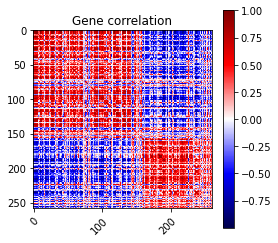

In [15]:
# Generates correlation matrix
corr_mx = data_ddr.corr()
features = data_ddr.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')


plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode="anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

In [16]:
X_ddr = data_ddr.values[ :, :-1].astype(np.float)
y_ddr = (data_ddr.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

Este modelo clasifica con un error de 0,6:

In [17]:
print('Error de Random Forest:', 1 - np.mean(rf_model.predict(X_ddr) == y_ddr))

Error de Random Forest: 0.6


#### Validación con datos de líneas celulares (Tsoi)

Son datos procedentes de 58 líneas celulares distintas resistentes a una sola droga (líneas SDR) y la mayoría de ellas no son las mismas que las utilizadas durante la construcción del modelo. La matriz de correlación con los 259 genes en estos datos es la siguiente:

In [18]:
data_tsoi = pd.read_table("data/tsoi-par.txt")

In [19]:
data_tsoi.describe();

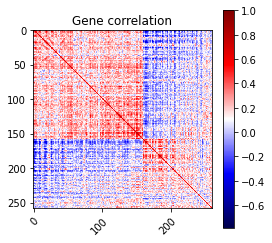

In [20]:
# Generates correlation matrix
corr_mx = data_tsoi.corr()
features = data_tsoi.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

El error obtenido con el clasificador de *Random Forest* es grande:

In [21]:
X_tsoi = data_tsoi.values[ :, :-1].astype(np.float)
y_tsoi = (data_tsoi.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [23]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_tsoi) == y_tsoi), 2))

Random Forest error: 0.34


Si se compara con el error obtenido durante la construcción de este clasificador (aproximadamente 0,13), es mucho más grande. Por tanto, es posible que se esté dando un sobreajuste del modelo, dado que al utilizar líneas diferentes a las utilizadas durante el entrenamiento se obtiene un error muy diferente.

#### Validación con xenoinjertos de A375 (Waizenegger)

Este conjunto de datos son 9 muestras de xenoinjertos de A375 resistentes y parentales en ratón. La matriz de correlaciones de los 259 genes es la siguiente:

In [24]:
data_waizenegger = pd.read_table("data/waizenegger.txt")

In [25]:
data_waizenegger.describe();

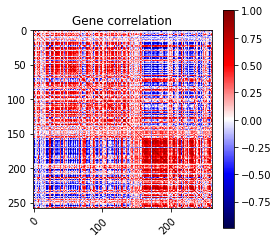

In [26]:
# Generates correlation matrix
corr_mx = data_waizenegger.corr()
features = data_waizenegger.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

La matriz es parecida a la obtenida al principio con los datos iniciales. Al usar *Random Forest* para clasificar los datos, se observa una mala actuación del modelo:

In [27]:
X_waizenegger = data_waizenegger.values[ :, :-1].astype(np.float)
y_waizenegger = (data_waizenegger.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [28]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_waizenegger) == y_waizenegger), 2))

Random Forest error: 0.67


#### Validación con PDX (Coppe)

Este conjunto de datos está formado por 95 muestras de xenoinjetos de tumores de pacientes parentales o resistentes en ratón. En la matriz de correlación de los TPMs transformados se intuyen los genes inducidos y reprimidos, pero la separación no es tan clara como en los casos anteriores:

In [29]:
data_coppe = pd.read_table("data/coppe.txt")
data_coppe.describe();

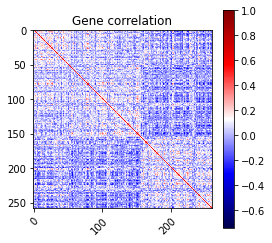

In [30]:
# Generates correlation matrix
corr_mx = data_coppe.corr()
features = data_coppe.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode="anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

In [31]:
X_coppe = data_coppe.values[ :, :-1].astype(np.float)
y_coppe = (data_coppe.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

Y el error del *Random Forest* es más grande que en el conjunto de datos anterior:

In [32]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_coppe) == y_coppe), 2))

Random Forest error: 0.67


#### Validación con células tratadas entre 21 y 59 días (biorxiv)

Este conjunto de datos tiene 15 muestras de 7 líneas celulares diferentes tratadas entre 21 y 59 días. En este caso, no están clasificadas como células resistentes, pero se comprobará si el clasificador es capaz de detectarlas como tal. La matriz de correlaciones se asemeja a la obtenida con los datos iniciales:

In [33]:
data_biorxiv = pd.read_table("data/biorxiv.txt")
data_biorxiv.describe();

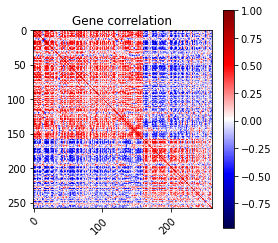

In [34]:
# Generates correlation matrix
corr_mx = data_biorxiv.corr()
features = data_biorxiv.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')


plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

El error del modelo es el siguiente:

In [35]:
X_biorxiv = data_biorxiv.values[ :, :-1].astype(np.float)
y_biorxiv = (data_biorxiv.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [36]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_biorxiv) == y_biorxiv), 2))

Random Forest error: 0.13


Tiene una buena actuación en este caso, probablemente porque los datos proceden de líneas celulares y porque 9 de 15 muestras proceden del mismo tipo de líneas que las que se incluyeron en la construcción del modelo. Dado este resultado, es posible que el modelo no sea capaz de distinguir células resistentes de células parentales tratadas.

#### Validación con tumores de pacientes en tratamiento (Song)

Estas son 22 muestras de tumores de pacientes antes y durante el tratamiento. Al igual que en el caso anterior, estas muestras no están clasificadas como resistentes, pero se utilizarán para comprobar si el clasificador las detecta como tal. La matriz muestra demasiado ruido:

In [37]:
data_song_pt = pd.read_table("data/song-pt.txt")
data_song_pt.describe();

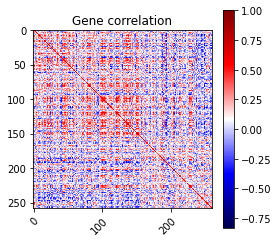

In [38]:
# Generates correlation matrix
corr_mx = data_song_pt.corr()
features = data_song_pt.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')


plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode="anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

In [39]:
X_song_pt = data_song_pt.values[ :, :-1].astype(np.float)
y_song_pt = (data_song_pt.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

Y el modelo tiene una mala actuación:

In [40]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_song_pt) == y_song_pt), 2))

Random Forest error: 0.38


#### Validación con tumores resistentes de pacientes (Hugo)

Este conjunto de datos tiene 61 muestras de tumores de pacientes antes y después del tratamiento. En este caso, los tratados sí que están clasificados como resistentes. La matriz de correlaciones es algo mejor que la anterior:

In [41]:
data_hugo_pt = pd.read_table("data/hugo-pt.txt")
data_hugo_pt.describe();

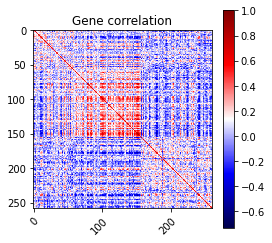

In [42]:
# Generates correlation matrix
corr_mx = data_hugo_pt.corr()
features = data_hugo_pt.columns

# Generates heatmap
fig, ax = plt.subplots(figsize = (4,4))
plt.imshow(corr_mx, cmap = 'seismic')

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
         rotation_mode = "anchor")

plt.colorbar()
ax.set_title("Gene correlation")
plt.show()

In [43]:
X_hugo_pt = data_hugo_pt.values[ :, :-1].astype(np.float)
y_hugo_pt = (data_hugo_pt.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

Y la actuación del modelo:

In [44]:
print('Random Forest error:', round(1 - np.mean(rf_model.predict(X_hugo_pt) == y_hugo_pt), 2))

Random Forest error: 0.38


## 2.2. Segunda aproximación: selección de genes de manera previa a la construcción del modelo

Como segunda aproximación, se hará una selección de genes de manera previa a la constricción de varios modelos. La evaluación se hará de mediante validación cruzada, al igual que en la primera aproximación. Con el fin de determinar el número de genes más adecuado para cada modelo, se hará la selección de distintos números de genes (`n_features`, que van del 1 al 99) con los datos de entrenamiento. Se valorarán en base a *Random Forest*, un método multivariante que puede encontrar conjuntos de genes que son útiles para la clasificación.

En este caso, se probarán cinco modelos diferentes: **Árbol de Decisión, *Support Vector Machine*, *Gradient Boosting*, Regresión Logística y Regresión Logística + regularización L2**. Los errores en función del número de genes son los siguientes:

In [45]:
# define n_features
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(100), 0.1))).astype(np.int))

# random forest to select features
rf = RandomForestClassifier(n_jobs = -1)

# decision trees to train the model
dt = DecisionTreeClassifier()

# svm to train the model
svm = SVC()

# gb to train the model
gb = GradientBoostingClassifier()

# logreg to train the model
logreg = LogisticRegression(penalty = 'none') 

# logreg + l2 penalty to train the model
logregl2 = LogisticRegression(penalty = 'l2') 

# repeated stratified K-fold setting the same random state as before
n_splits = 10
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 0)

# errors arrays
errors_dt = np.zeros((n_splits * n_repeats, len(n_features)))
errors_svm = np.zeros((n_splits * n_repeats, len(n_features)))
errors_gb = np.zeros((n_splits * n_repeats, len(n_features)))
errors_logreg = np.zeros((n_splits * n_repeats, len(n_features)))
errors_logregl2 = np.zeros((n_splits * n_repeats, len(n_features)))

In [ ]:
split = 0

for train_index, test_index in rskf.split(X, y):

#     print('Split number ', split, ' ------------------------------')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # to loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
#         print('\tIteration number', i,  '------------------------------')        
    
        # select the X_i best features based on random forest
        # specify a threshold value equal to zero; then it will be increased to choose only n feautres
        rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 2000, random_state = split), \
                                        threshold = 0.0)
        
        # Filter using random forest
#         print('\t\tSelecting the best {0} features based on random forest...'
#              .format(n_features[ len(n_features) - i - 1 ]))
        rf_selection.fit(X_train, y_train)
        rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ \
                                                  n_features[ len(n_features) - i - 1 ] ] # -1 to correct 0-index
        X_train_rf = rf_selection.transform(X_train)
        X_test_rf = rf_selection.transform(X_test)

        # fit the classifier on the training data and evaluate its performance on the
        # test data
        
#         print('\t\tFitting and evaluating the classifier...')
        
        # train the models
        dt.fit(X_train_rf, y_train)
        svm.fit(X_train_rf, y_train)
        gb.fit(X_train_rf, y_train)
        logreg.fit(X_train_rf, y_train)
        logregl2.fit(X_train_rf, y_train)
        
        # save errors
        errors_dt[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(dt.predict(X_test_rf) == y_test)
        errors_svm[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(svm.predict(X_test_rf) == y_test)
        errors_gb[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(gb.predict(X_test_rf) == y_test)
        errors_logreg[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(logreg.predict(X_test_rf) == y_test)
        errors_logregl2[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(logregl2.predict(X_test_rf) == y_test)

    split += 1

In [ ]:
# compute mean errors and the corresponding standard deviations

# decision tree
error_dt = np.mean(errors_dt, 0)
error_std_dt = np.std(errors_dt, 0) / np.sqrt(errors_dt.shape[ 0 ])

# svm
error_svm = np.mean(errors_svm, 0)
error_std_svm = np.std(errors_svm, 0) / np.sqrt(errors_svm.shape[ 0 ])

# gb
error_gb = np.mean(errors_gb, 0)
error_std_gb = np.std(errors_gb, 0) / np.sqrt(errors_gb.shape[ 0 ])

# logreg
error_logreg = np.mean(errors_logreg, 0)
error_std_logreg = np.std(errors_logreg, 0) / np.sqrt(errors_logreg.shape[ 0 ])

# logreg l2
error_logregl2 = np.mean(errors_logregl2, 0)
error_std_logregl2 = np.std(errors_logregl2, 0) / np.sqrt(errors_logregl2.shape[ 0 ])

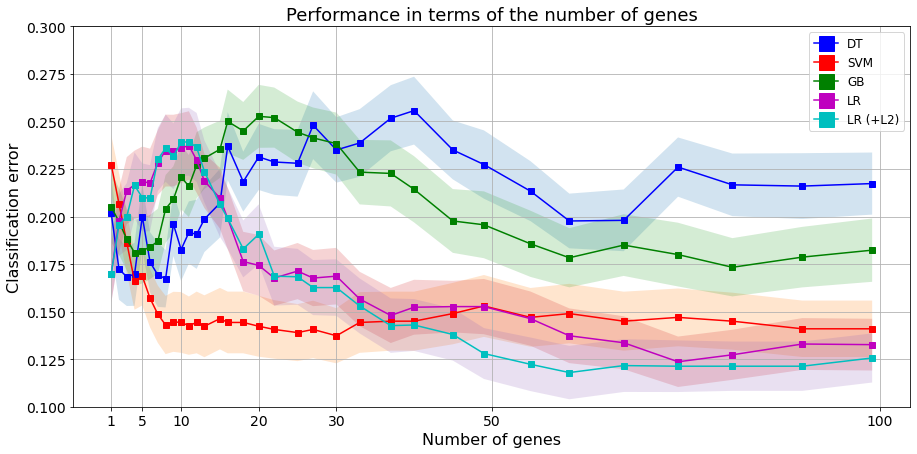

In [11]:
# the axis legend will consider a subset of the features tested

plt.figure(figsize=(15,7))

line1, = plt.plot(n_features, error_dt, 's-', color="b")
line2, = plt.plot(n_features, error_svm, 's-', color="r")
line3, = plt.plot(n_features, error_gb, 's-', color="g")
line4, = plt.plot(n_features, error_logreg, 's-', color="m")
line5, = plt.plot(n_features, error_logregl2, 's-', color="c")

plt.fill_between(n_features, error_dt - error_std_dt, error_dt + error_std_dt, alpha=0.2)
plt.fill_between(n_features, error_svm - error_std_svm, error_svm + error_std_svm, alpha=0.2)
plt.fill_between(n_features, error_gb - error_std_gb, error_gb + error_std_gb, alpha=0.2)
plt.fill_between(n_features, error_logreg - error_std_logreg, error_logreg + error_std_logreg, alpha=0.2)
plt.fill_between(n_features, error_logregl2 - error_std_logregl2, error_logregl2 + error_std_logregl2, alpha=0.2)

plt.grid()

plt.title("Performance in terms of the number of genes", size = 18)

plt.xlabel('Number of genes', size = 16)
plt.xticks(np.array([1, 5, 10, 20, 30, 50, 100]), size = 14)

plt.ylabel('Classification error', size = 16)
plt.yticks(size = 14)
plt.ylim((0.1, 0.3))

legend_handles = [ mlines.Line2D([], [], color = 'b', marker = 's', markersize = 15, \
                                 label = 'DT'),
                  mlines.Line2D([], [], color = 'r', marker = 's', markersize = 15, \
                                label = 'SVM'),
                  mlines.Line2D([], [], color = 'g', marker = 's', markersize = 15, \
                                label = 'GB'),
                  mlines.Line2D([], [], color = 'm', marker = 's', markersize = 15, \
                                label = 'LR'),
                  mlines.Line2D([], [], color = 'c', marker = 's', markersize = 15, \
                                label = 'LR (+L2)')]

plt.legend(handles = legend_handles, loc = 1, fontsize = 12);

<font size="2">Nota: DT indica Árbol de decisión, SVM *Support Vector Machine*, GB *Gradient Boosting*, LR *Regresión Logística* y LR+L2 Regresión Logística con regularización L2.</font>

Se observa que SVM disminuye su error a medida que se utilizan más genes, viéndose una disminuición considerable del error tras la selección de 8. Con el resto de clasificadores no se observa lo mismo. De hecho, los dos modelos de regresión logística comienzan a actuar de manera similar o mejor qe SVM cuando el número de genes seleccionado se acerca al número de muestras (52), lo que puede ser un indicio de que se está dando un sobreajuste de los modelos.

### 2.2.1. Selección de genes

Como muestra el gráfico, el número de genes más adecuado para la clasificación depende del modelo. De todos ellos, uno de los que mejores resultados obtuvo fue SVM con 8 genes. Para seleccionar los 8 mejores genes según *Random Forest*, se pueden hacer 100 iteraciones de la selección para comprobar cuáles son los 8 más elegidos, esta vez utilizando todos los datos:

In [78]:
genes = data.columns[:-1]
sel_genes = []

In [79]:
for i in range(100):
        
#     print('\tIteration number', i,  '------------------------------')        
    
#     print('\t\tSelecting the best 8 features based on random forest...')
    rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 2000), threshold = 0.0)
    rf_selection.fit(X, y)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ 7 ] # 8-1 (0-index)
    
    # transform
    X_sel = rf_selection.transform(X)
    
    # identify columns and add gene name to a list
    for i in range(X_sel.shape[1]):
        for j in range(X.shape[1]):
            if np.array_equal(X_sel[ : , i], X[ : , j]): sel_genes.append(genes[ j ])

Los genes seleccionados después de todas las iteraciones fueron los siguientes:

In [80]:
dict_sel_genes = Counter(sel_genes)
dict_sel_genes = {k: v for k, v in sorted(dict_sel_genes.items(), reverse = True, key=lambda item: item[1])}

for i in dict_sel_genes.items():
    print('\t', i[0], 'was selected', i[1], 'times.')

	 ENSG00000147100 was selected 100 times.
	 ENSG00000158828 was selected 100 times.
	 ENSG00000179388 was selected 100 times.
	 ENSG00000261857 was selected 100 times.
	 ENSG00000091409 was selected 100 times.
	 ENSG00000183671 was selected 98 times.
	 ENSG00000182326 was selected 98 times.
	 ENSG00000178445 was selected 69 times.
	 ENSG00000110031 was selected 15 times.
	 ENSG00000123358 was selected 14 times.
	 ENSG00000164778 was selected 5 times.
	 ENSG00000175471 was selected 1 times.


In [104]:
# take the first 8 genes
sel_genes = list(dict_sel_genes.keys())[:8]

In [47]:
X_sel = data[sel_genes].values
X_sel.shape;

Un PCA de los datos antes y después de la selección muestra lo siguiente:

In [119]:
# pca using the original data
pca_original = PCA(n_components = 2) 
# pca using the 8 genes selected
pca_sel = PCA(n_components = 2) 

# project 259 to 2 dimensions according to the PCA components
X_pca_or = pca_original.fit(X).transform(X)
X_pca_sel = pca_sel.fit(X_sel).transform(X_sel)

# print some information:
print('Original shape (rows, cols):', X.shape) # shape of the original data frame
print('New shape (rows, cols):', X_sel.shape) # shape of data frame after gene selection

print('\nVariance accounted for by the first 2 components using the original data: %s'
      % str(pca_original.explained_variance_ratio_))

print('Total: %s'
      % str(np.cumsum(pca_original.explained_variance_ratio_)[-1]))
print('\nVariance accounted for by the first 2 components using the data after selection of 8 genes: %s'
      % str(pca_sel.explained_variance_ratio_))

print('Total: %s'
      % str(np.cumsum(pca_sel.explained_variance_ratio_)[-1]))

Original shape (rows, cols): (52, 259)
New shape (rows, cols): (52, 8)

Variance accounted for by the first 2 components using the original data: [0.3850515  0.09998089]
Total: 0.4850323964916503

Variance accounted for by the first 2 components using the data after selection of 8 genes: [0.71833024 0.08237762]
Total: 0.8007078589449954


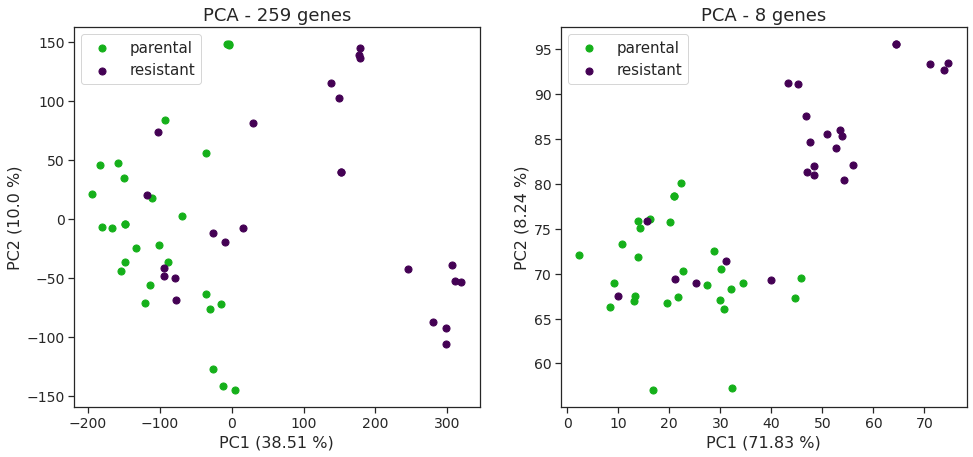

In [118]:
## Now plot the labelled data:
    
comp1 = 0; # first component to visualize
comp2 = 1; # second component to visualize

plt.figure(figsize=(16,7))


# PCA - 259 genes

plt.subplot(1,2,1)

plt.scatter(X_pca_or[y == 0, comp1], X_pca_or[y == 0, comp2], color = '#15B01A', s = 50,lw = 1,
                label = 'parental')
plt.scatter(X_pca_or[y == 1, comp1], X_pca_or[y == 1, comp2], color = '#440154FF', s = 50,lw = 1,
                label = 'resistant')

plt.xlabel('PC1 ({} %)'.format(str(round(pca_original.explained_variance_ratio_[0], 4)*100)), size = 16)
plt.ylabel('PC2 ({} %)'.format(str(round(pca_original.explained_variance_ratio_[1], 4)*100)), size = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.legend(loc='upper left', shadow = False, scatterpoints = 1, fontsize = 15)
plt.title('PCA - 259 genes', size = 18)


# PCA - 8 genes

plt.subplot(1,2,2)

plt.scatter(X_sel[y == 0, comp1], X_sel[y == 0, comp2], color = '#15B01A', s = 50,lw = 1,
                label = 'parental')
plt.scatter(X_sel[y == 1, comp1], X_sel[y == 1, comp2], color = '#440154FF', s = 50,lw = 1,
                label = 'resistant')

plt.xlabel('PC1 ({} %)'.format(str(round(pca_sel.explained_variance_ratio_[0], 4)*100)), size = 16)
plt.ylabel('PC2 ({} %)'.format(str(round(pca_sel.explained_variance_ratio_[1], 4)*100)), size = 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.legend(loc = 'upper left', shadow = False, scatterpoints = 1, fontsize = 15)
plt.title('PCA - 8 genes',  size = 18);

Se observa que siguen separándose los dos grupos tras la selección de los 8 genes, aunque no se consigue una separación completa en ninguno de los casos.

Explorando mejor los genes seleccionados, se observa que todas las distribuciones solapan en algún rango:

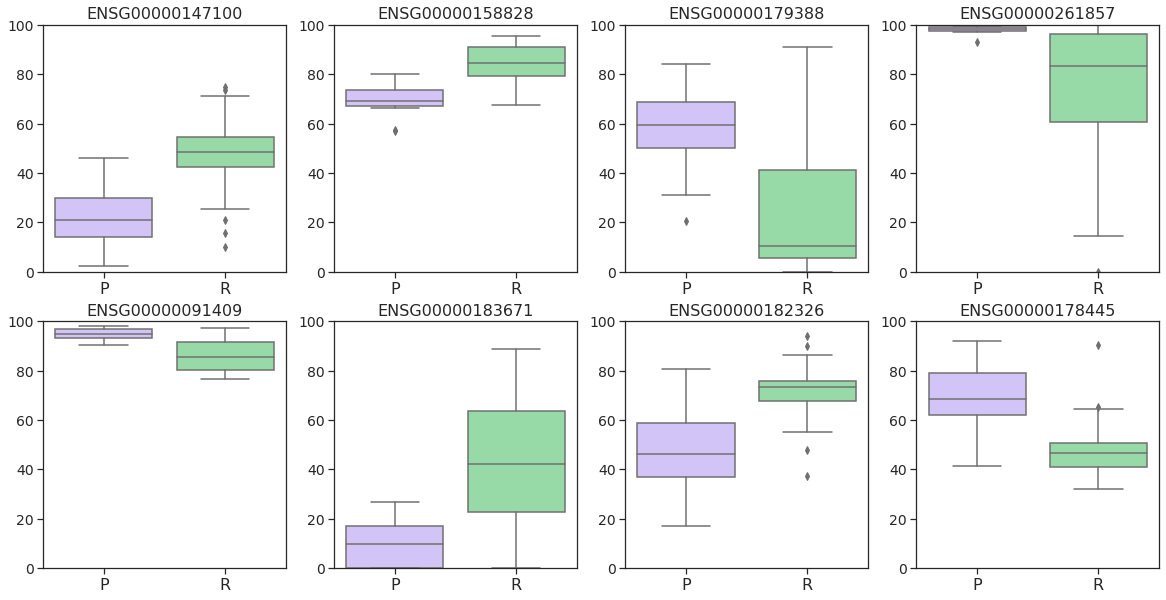

In [90]:
sns.set_theme(style = "ticks", palette = "pastel")

plt.figure(figsize = (20, 10))

i = 0
for gg in sel_genes:
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x = "phenotype", y =  gg, palette = ["m", "g"],
                data = data)
    plt.ylabel('')
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.title(gg, size = 16)
    
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 14)

    i += 1

### 2.2.2. Construcción de un clasificador SVM (con 8 genes)

La mejor opción de modelo de la segunda aproximación fue SVM con la selección de 8 genes. Por este motivo, se seleccionaron los 8 mejores genes para la clasificación y se entrenó un modelo SVM con ellos. Se optó por utilizar los hiperparámetros por defecto (`C = 1`, `gamma = 1`) y los seleccionados tras una "búsqueda exhaustiva":

In [48]:
svm_model = SVC()
svm_model.fit(X_sel, y);

In [49]:
# grid search
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf', 'poly']}
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_sel,y);

In [50]:
grid.best_estimator_

SVC(C=1, gamma=0.0001)

### 2.2.3. Validación

#### Validación con datos de líneas resistentes a dos drogas

Con este modelo, los resultados también tienen bastante error:

In [51]:
X_ddr_sel = data_ddr[sel_genes].values.astype(np.float)
y_ddr = (data_ddr.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [52]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_ddr_sel) == y_ddr), 2))

SVM error (default hyperparameters): 0.4


In [53]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_ddr_sel) == y_ddr), 2))

SVM error (best hyperparameters): 0.4


#### Validación con líneas celulares (Tsoi)

Con este clasificador, el error es algo menor que con *Random Forest*:

In [54]:
X_tsoi_sel = data_tsoi[sel_genes].values.astype(np.float)
y_tsoi = (data_tsoi.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [55]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_tsoi_sel) == y_tsoi), 2))

SVM error (default hyperparameters): 0.29


In [56]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_tsoi_sel) == y_tsoi), 2))

SVM error (best hyperparameters): 0.28


Sin embargo, sigue siendo superior al error del entrenamiento.

#### Validación con xenoinjertos de A375 (Waizenegger)

Con los datos de xenoinjertos de la línea A375 en ratón, el error es muy grande:

In [57]:
X_waizenegger_sel = data_waizenegger[sel_genes].values.astype(np.float)
y_waizenegger = (data_waizenegger.values[ :, -1 ]=='R').astype(np.int) # 0 assigned to P and 1 to R

In [58]:
print('SVM error (default hyperparameters):', round(1 - np.mean(grid.predict(X_waizenegger_sel) == y_waizenegger), 2))

SVM error (default hyperparameters): 0.78


In [59]:
print('SVM error (best hyperparameters):', round(1 - np.mean(svm_model.predict(X_waizenegger_sel) == y_waizenegger), 2))

SVM error (best hyperparameters): 0.67


#### Validación con PDX (Coppe)

Con los datos de PDX en ratones:

In [60]:
X_coppe_sel = data_coppe[sel_genes].values.astype(np.float)

In [61]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_coppe_sel) == y_coppe), 2))

SVM error (default hyperparameters): 0.53


In [62]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_coppe_sel) == y_coppe), 2))

SVM error (best hyperparameters): 0.56


#### Validación con líneas tratadas entre 21 y 59 días (biorxiv)

Con las líneas tratadas entre 21 a 59 días:

In [63]:
X_biorxiv_sel = data_biorxiv[sel_genes].values.astype(np.float)
y_biorxiv = (data_biorxiv.values[ :, -1 ] == 'R').astype(np.int) # 0 assigned to P and 1 to R

In [64]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_biorxiv_sel) == y_biorxiv), 2))

SVM error (default hyperparameters): 0.27


In [65]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_biorxiv_sel) == y_biorxiv), 2))

SVM error (best hyperparameters): 0.27


Algo mejor que en el conjunto de datos anterior.

#### Validación con tumores de pacientes en tratamiento (Song)

Con estos datos de tumores de pacientes antes y durante el tratamiento:

In [66]:
X_song_pt_sel = data_song_pt[sel_genes].values.astype(np.float)

In [67]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_song_pt_sel) == y_song_pt), 2))

SVM error (default hyperparameters): 0.33


In [68]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_song_pt_sel) == y_song_pt), 2))

SVM error (best hyperparameters): 0.33


#### Validación con tumores resistentes de pacientes (Hugo)

Con estos tumores de pacientes antes y después del tratamiento (tumores resistentes):

In [69]:
X_hugo_pt_sel = data_hugo_pt[sel_genes].values.astype(np.float)

In [70]:
print('SVM error (default hyperparameters):', round(1 - np.mean(svm_model.predict(X_hugo_pt_sel) == y_hugo_pt), 2))

SVM error (default hyperparameters): 0.38


In [71]:
print('SVM error (best hyperparameters):', round(1 - np.mean(grid.predict(X_hugo_pt_sel) == y_hugo_pt), 2))

SVM error (best hyperparameters): 0.36


La actuación del modelo también es mala.

# 3. Resultados y conclusiones

La actuación del modelo elegido de la **primera aproximación**, *Random Forest*, con los datos de validación fue la siguiente:

| Datos | Error |
| --- | --- |
| Líneas DDR | 0,6 |
| Líneas SDR | 0,34 |
| Xenoinjertos A375 | 0,67 |
| PDX resistentes | 0,67 |
| Líneas tratadas 21-59 d | 0,13 |
| Tumores tratados | 0,38 |
| Tumores resistentes | 0,38 |

Mientras que la actuación del modelo elegido de la **segunda aproximación**, SVM con 8 genes, fue:

| Datos | Error |
| --- | --- |
| Líneas DDR | 0,4 |
| Líneas SDR | 0,28 |
| Xenoinjertos A375 | 0,67 |
| PDX resistentes | 0,53 |
| Líneas tratadas 21-59 d | 0,27 |
| Tumores tratados | 0,33 |
| Tumores resistentes | 0,36 |

Se observa que ambos modelos tienen una mala actuación, en especial con datos que proceden de xenoinjertos. Dada la distinta procedencia de los datos (líneas celulares, tumores de pacientes y xenoinjertos de líneas y de tumores de pacientes), es posible que se necesiten distintas estrategias para la clasificación de cada uno de ellos.

Aun habiendo entrenado los modelos con datos procedentes de líneas celulares, con los datos de validación que también proceden de líneas tampoco se obtuvieron buenos resultados en general. El conjunto de datos de líneas SDR está formado por tipos celulares más diversos que los del entrenamiento, y los errores de su clasificación fueron igual o superiores a 0,28. Esto puede indicar que los modelos están sobreajustados a los datos de entrenamiento y que son incapaces de generalizar a la hora de clasificar otras líneas. Por otro lado, *Random Forest* obtuvo una buena puntuación con datos de líneas tratadas 21-59 d, a pesar de que éstas no estuvieran etiquetadas como resistentes. Es posible que este tipo de modelos también pudieran servir para distinguir células parentales que toleran la droga pero que aún no lo son.

Para mejorar la actuación de los clasificadores, sería necesario partir de un número más grande de datos y líneas más variadas, además de comprobar si los clasificadores pueden distinguir células parentales tratadas a tiempo corto y células resistentes o parentales que toleran la droga.